In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from datetime import timedelta
from matplotlib.ticker import MultipleLocator


import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor

from sklearn import model_selection, preprocessing, metrics, tree
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import make_scorer , confusion_matrix, mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.svm import SVR

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

seed_val = 42

/kaggle/dev/jovan/mercedes-benz-greener-manufacturing/venv-mercedes/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# constants
DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/raw_data/'
SUBMISSION_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/submissions'

In [3]:
# loading the data
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

In [4]:
target_col = ['y']
predictor_cols = [col for col in train.columns if col not in target_col]

train_x = train[predictor_cols]
train_y = train[target_col]
test_x = test[predictor_cols]

In [5]:
def xgb_r2(y_pred, dtrain):
    y_true = dtrain.get_label()
    r2_sklearn = r2_score(y_true, y_pred)
    r2_sklearn = r2_sklearn * -1.0
    return 'error', r2_sklearn

def stacking_regressor(train_x, train_y, test_x, n_folds, estimators, train_eval_metric, 
                       compare_eval_metric, blending, blend_eval_metric, pred_cols, blend_val_size):
    
    start_time = time.time()
        
    print('--- removing extra columns from train and test datasets ---')
    train_x = train_x.drop('ID', 1)
    test_x = test_x.drop('ID', 1)
    
                
    print('--- encoding columns from train and test datasets ---')
    for f in train_x.columns:
        if train_x[f].dtype=='object':
            print('encoding column:', f, '(original dtype:', train_x[f].dtype, ')')
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(set(train_x[f].values)| set(test_x[f].values))) 
            train_x[f] = lbl.transform(list(train_x[f].values))
            test_x[f] = lbl.transform(list(test_x[f].values))

               
#     #zero-centering and normalizing
#     print('--- zero-centering and normalizing columns from train and test datasets ---')
#     for i in train_x.columns:
#         if not(i in ['ID']):
#             col_mean = np.mean(train_x[i], axis=0)
#             col_std = np.std(train_x[i], axis=0)
#             train_x[i] = (train_x[i]-col_mean)/col_std

#     for i in test_x.columns:
#         if not(i in ['ID']):
#             col_mean = np.mean(test_x[i], axis=0)
#             col_std = np.std(test_x[i], axis=0)
#             test_x[i] = (test_x[i]-col_mean)/col_std
    
    # initializing blending data frames
    train_x_blend = train_x
    test_x_blend = test_x
    train_y_blend = train_y

    
    # converting to numpy for stacking
    train_x = train_x.as_matrix()
    train_y = (train_y).values.ravel()
    test_x = test_x.as_matrix()
    
            
    # Note: StratifiedKFold splits into roughly 66% train 33% test  
    skf = list(StratifiedKFold(train_y, n_folds, random_state=seed_val))
    
    
    dataset_blend_train = np.zeros((train_x.shape[0], len(estimators)))
    dataset_blend_test = np.zeros((test_x.shape[0], len(estimators)))
    
    for j, estimator in enumerate(estimators):
        dataset_blend_test_j = np.zeros((test_x.shape[0], len(skf)))
        for i, (train, test) in enumerate(skf):
            print('fold:', i+1, '/', n_folds, '; estimator:',  j+1, '/', len(estimators))
            trn_x = train_x[train, :] 
            trn_y = train_y[train]
            val_x = train_x[test, :] 
            val_y = train_y[test]

            # if xgb
            if ( 'dict' in str(type(estimator))):
                eval_set = [(trn_x, trn_y),(val_x, val_y)]
                model = XGBRegressor(**estimator).fit(trn_x, trn_y, eval_set=eval_set, verbose=False, 
                                                eval_metric=train_eval_metric)
            
            # else sklean
            else:          
                model = estimator.fit(trn_x, trn_y)
                
            pred_train = model.predict(val_x)
            dataset_blend_train[test, j] = pred_train

            pred_test = model.predict(test_x[:,:])
            dataset_blend_test_j[:, i] = pred_test
    
        dataset_blend_test[:, j] = np.mean(dataset_blend_test_j, axis=1)
        
        
    print('--- comparing models ---')
    # comparing models
    for i in range(dataset_blend_train.shape[1]):
        print('model', i+1, ':', compare_eval_metric(train_y, dataset_blend_train[:,i]))
    
    # initializing test_y
    test_y = model.predict(test_x)
    blended_model = model
    if blending:
        print('--- blending ---')
        
        for i, j in enumerate(estimators):
            train_x_blend[pred_cols[i]] = dataset_blend_train[:,i]
            test_x_blend[pred_cols[i]] = dataset_blend_test[:,i]
        
        
        trn_x, val_x, trn_y, val_y = model_selection.train_test_split(train_x_blend, train_y_blend, 
                                                                      test_size=blend_val_size, 
                                                                      random_state=seed_val)
       
        estimator = estimators[0]
        eval_set =[(trn_x, trn_y), (val_x, val_y)]
        model = XGBRegressor(**estimator).fit(trn_x, trn_y, eval_set=eval_set, verbose=False, 
                                              eval_metric=blend_eval_metric)
        blended_model = model
        test_y = model.predict(test_x_blend)
        val_pred_y = model.predict(val_x)
        print('blended model:', compare_eval_metric(val_y, val_pred_y))
    
    end_time = time.time()
    print("Total Time usage: " + str(timedelta(seconds=int(round(end_time - start_time)))))
    return dataset_blend_train, test_y, blended_model

In [6]:
# Predictors
estimators = [{
        'objective': "reg:linear",
        'max_depth': 10,
        'learning_rate': 0.05,
        'nthread': 12,
        'seed': seed_val,
        'subsample': 0.8,
        'silent': True
    }]#,
#     RandomForestRegressor(n_estimators=10, n_jobs=-1,  random_state=seed_val),
#     ExtraTreesRegressor(n_estimators=10, n_jobs=-1, random_state=seed_val),
#     GradientBoostingRegressor(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=50, random_state=seed_val)]

pred_cols = ['pred1_xgb_y_pred', 
             'pred1_rf_y_pred', 
             'pred1_et_y_pred',
             'pred1_gb_y_pred']

# stacking 
dataset_blend_train, test_y, blended_model = stacking_regressor(train_x, 
                                                                 train_y, 
                                                                 test_x, 
                                                                 n_folds = 3, 
                                                                 estimators=estimators, 
                                                                 train_eval_metric=xgb_r2,
                                                                 compare_eval_metric=r2_score,
                                                                 blending=True,
                                                                 blend_eval_metric=xgb_r2,
                                                                 pred_cols = pred_cols,
                                                                 blend_val_size=0.33)

--- removing extra columns from train and test datasets ---
--- encoding columns from train and test datasets ---
encoding column: X0 (original dtype: object )
encoding column: X1 (original dtype: object )
encoding column: X2 (original dtype: object )
encoding column: X3 (original dtype: object )
encoding column: X4 (original dtype: object )
encoding column: X5 (original dtype: object )
encoding column: X6 (original dtype: object )
encoding column: X8 (original dtype: object )


/kaggle/dev/jovan/mercedes-benz-greener-manufacturing/venv-mercedes/lib/python3.5/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


fold: 1 / 3 ; estimator: 1 / 1
fold: 2 / 3 ; estimator: 1 / 1
fold: 3 / 3 ; estimator: 1 / 1
--- comparing models ---
model 1 : 0.494841674534
--- blending ---
blended model: 0.46404349199
Total Time usage: 0:00:03


In [7]:
post_analysis = train_x[predictor_cols]
for i, j in enumerate(estimators):
    post_analysis[pred_cols[i]] = dataset_blend_train[:,i]

In [8]:
print('--- encoding columns from train and test datasets ---')
for f in post_analysis.columns:
    if post_analysis[f].dtype=='object':
        print('encoding column:', f, '(original dtype:', post_analysis[f].dtype, ')')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(set(post_analysis[f].values))) 
        post_analysis[f] = lbl.transform(list(train_x[f].values))
            
post_analysis['y_pred'] = blended_model.predict(
    post_analysis.loc[:, [col for col in post_analysis.columns if col not in ['ID']]])
post_analysis['y_true'] = train_y

--- encoding columns from train and test datasets ---
encoding column: X0 (original dtype: object )
encoding column: X1 (original dtype: object )
encoding column: X2 (original dtype: object )
encoding column: X3 (original dtype: object )
encoding column: X4 (original dtype: object )
encoding column: X5 (original dtype: object )
encoding column: X6 (original dtype: object )
encoding column: X8 (original dtype: object )


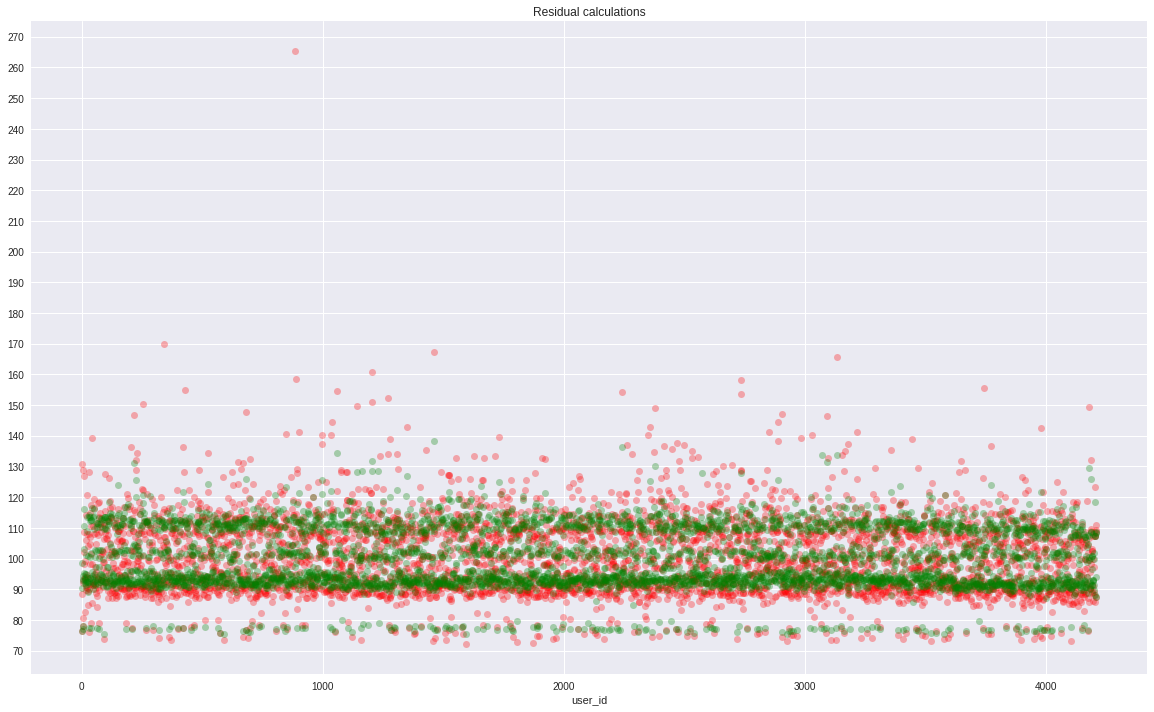

In [9]:
majorLocator = MultipleLocator(10)

fix, ax = plt.subplots(figsize=(20,12))
plt.title('Residual calculations')
plt.xlabel('user_id')
plt.plot(post_analysis['y_true'],'ro', alpha=0.30)
plt.plot(post_analysis['y_pred'],'go', alpha=0.30)
ax.yaxis.set_major_locator(majorLocator)
plt.show()

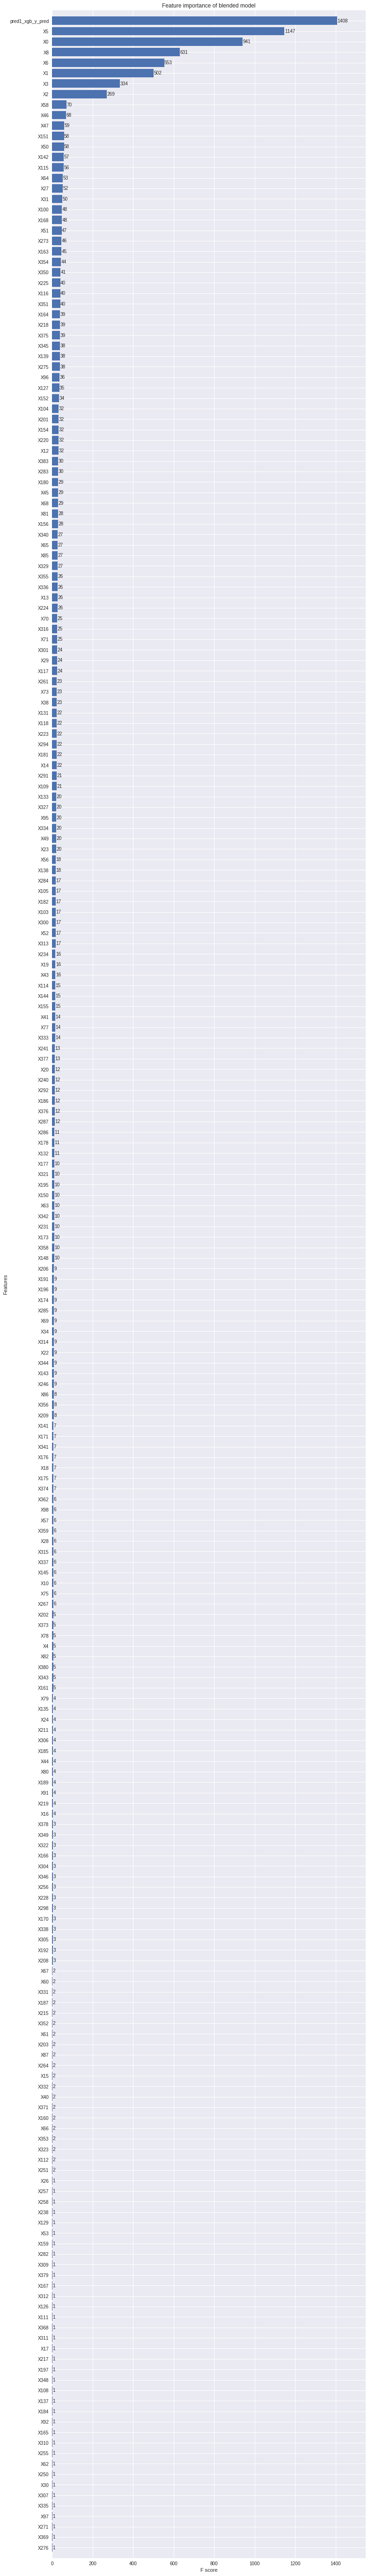

In [10]:
fig, ax = plt.subplots(figsize=(12,100))
xgb.plot_importance(blended_model, height=0.8, ax=ax, title='Feature importance of blended model')

### Submission

In [11]:
def generate_submission_file(output_path, test_x, test_y, team_name):
    test_x['y'] = test_y
    test_x = test_x[['ID', 'y']]
    
    # Preparing to output
    timestamp = str(int(time.time()))
    filename = output_path + '/submission-' + team_name + '-' + timestamp + ".csv"
    test_x.to_csv(filename, index=False)
    print('output filename:', filename)

In [12]:
team_name = 'jsardinha'
#generate_submission_file(SUBMISSION_PATH, test_x, test_y, team_name)